In [37]:
import sys
import os
#import torch
import zarr
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from scipy.stats import linregress

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data

### EOBS investigation

In [158]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']

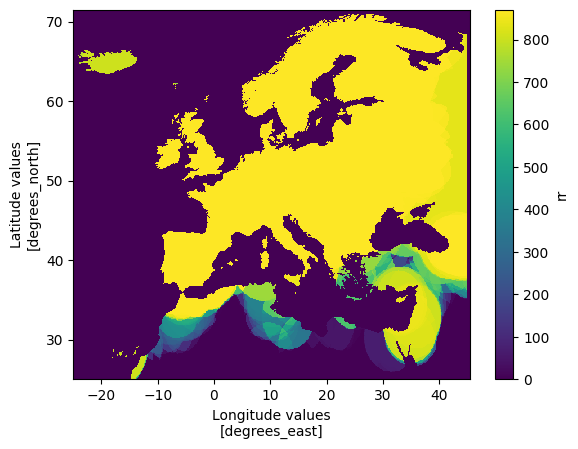

In [43]:
rrmon.count('time').plot()

In [121]:
test = rrmon.sel(latitude = 40,longitude = [28,30], method = 'nearest')
days_since_1950 = (time - pd.Timestamp('1950-01-01')).days

In [160]:
def xr_linregress(y, x, min_count = 30):
    """
    Removal of NaNs because scipy linregress cannot handle
    # Or switch to. 
    """
    isnan = np.isnan(y)
    y = y[~isnan]
    x = x[~isnan]
    #print(f"y: {y.shape} | x: {x.shape}")
    if len(y) >= min_count:
        reg_result = linregress(x = x, y = y)
        result = [reg_result[1], reg_result[0] * 365] # intercept, slope [year-1]
    else:
        result = [np.nan, np.nan]
    #return xr.DataArray(np.array(result, dtype = np.float32), dims = ('what',), coords = {'what':})
    return np.array(result,dtype = np.float32)

In [122]:
xr_linregress(x = days_since_1950, y = test)

y: (870, 2) | x: (870,)


IndexError: 2-dimensional boolean indexing is not supported. 

In [162]:
coefs = xr.apply_ufunc(xr_linregress, rrmon, days_since_1950, exclude_dims = set(("time",)),
                       input_core_dims=[['time'],['time']],
                       output_core_dims=[['what']], 
                       vectorize = True, dask = "parallelized",
                       output_dtypes=[np.float32], output_sizes={'what':2})
coefs.coords.update({'what':['intercept','slope']})

/tmp/ipykernel_278021/633920586.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  coefs = xr.apply_ufunc(xr_linregress, rrmon, days_since_1950, exclude_dims = set(("time",)),


In [164]:
c = coefs.compute()

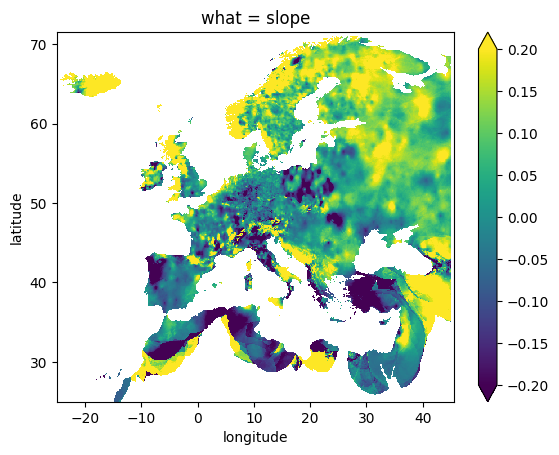

In [168]:
c[:,:,1].plot(vmin = -0.2, vmax = 0.2)

In [27]:
spimon = xr.open_dataarray('/scistor/ivm/jsn295/Medi/monthly/spi3_mon_0.1deg_reg_ens_median_E-OBSv23.1e.zarr/', engine = 'zarr')

In [ ]:
# Maps of trend per season.
# Visualizing number of valid obs.

### WP3 investigation

In [4]:
window = 90
wsd = xr.open_dataset('/scistor/ivm/jsn295/Medi/monthly/1979_2021_water_surplus_deficit_monthly.zarr', engine = 'zarr')[f'spei_{window}']

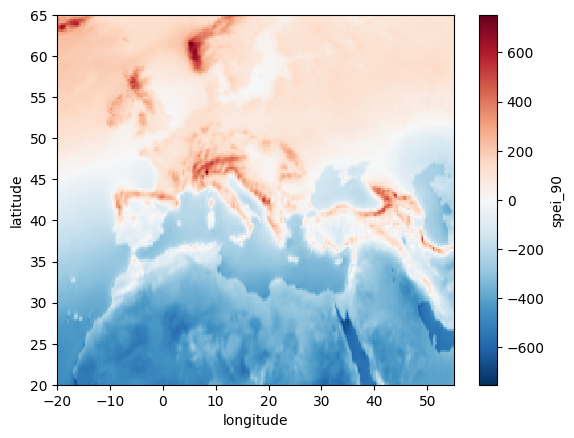

In [7]:
wsd[:100,:,:].sum('time').plot()

In [9]:
wsd.encoding

{'chunks': (1, 50, 50),
 'preferred_chunks': {'time': 1, 'latitude': 50, 'longitude': 50},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}